In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Step 1 - Install Packages + Download Data + Extract Data

In [1]:
!pip install -q transformers datasets torch torchvision Pillow PyMuPDF huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 63.0 MB/s eta 0:00:00:00:0100:01


In [2]:
import tarfile
import os
from huggingface_hub import hf_hub_download

# Create folders (Kaggle writable directory)
os.makedirs("/kaggle/working/annotations", exist_ok=True)
os.makedirs("/kaggle/working/images", exist_ok=True)

# Download + extract annotations
print("Downloading annotations...")

ann_path = hf_hub_download(
    repo_id="bsmock/pubtables-1m",
    filename="PubTables-1M-Detection_Annotations_Train.tar.gz",
    repo_type="dataset"
)

with tarfile.open(ann_path, "r:gz") as tar:
    tar.extractall("/kaggle/working/annotations")

print("✓ Annotations extracted")

# Download + extract 0.5% images
print("\nDownloading images Part1...")

img_path = hf_hub_download(
    repo_id="bsmock/pubtables-1m",
    filename="PubTables-1M-Detection_Images_Train_Part1.tar.gz",
    repo_type="dataset"
)

with tarfile.open(img_path, "r:gz") as tar:
    members = tar.getmembers()
    part = int(len(members) * 0.005)  # take 0.5%
    tar.extractall("/kaggle/working/images", members=members[:part])

print("✓ Images extracted")

print("\n✅ Done!")
print("Annotations folder: /kaggle/working/annotations/")
print("Images folder: /kaggle/working/images/")

/tmp/ipykernel_206/4202342935.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("/kaggle/working/annotations")


✓ Annotations extracted



PubTables-1M-Detection_Images_Train_Part(…):   0%|          | 0.00/30.8G [00:00<?, ?B/s]

/tmp/ipykernel_206/4202342935.py:35: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("/kaggle/working/images", members=members[:part])


✓ Images extracted

✅ Done!
Annotations folder: /kaggle/working/annotations/
Images folder: /kaggle/working/images/


### Step 2 - Check extracted annotation and image folders

In [3]:
import os

# Quickly explore how annotation files are organized after extraction
print("Annotations folder:")
for root, dirs, files in os.walk("/kaggle/working/annotations"):
    level = root.replace("/kaggle/working/annotations", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:
        subindent = " " * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

# Do the same check for extracted image files
print("\nImages folder:")
for root, dirs, files in os.walk("/kaggle/working/images"):
    level = root.replace("/kaggle/working/images", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:
        subindent = " " * 2 * (level + 1)
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

Annotations folder:
annotations/
  PMC4869179_4.xml
  PMC3444320_4.xml
  PMC6142692_2.xml
  PMC4452231_9.xml
  PMC6208117_5.xml
  ... and 460584 more files

Images folder:
images/
  PMC3355040_3.jpg
  PMC4447415_7.jpg
  PMC3267652_3.jpg
  PMC3022848_4.jpg
  PMC2386811_2.jpg
  ... and 1146 more files


### Step 3 - Locate image and annotation folders after extraction

In [4]:
import os
import glob

# Look for image and annotation files inside Kaggle directories
# Kaggle already unzips datasets, so we point directly to working folders
img_files = glob.glob("/kaggle/working/images/**/*.png", recursive=True) + \
            glob.glob("/kaggle/working/images/**/*.jpg", recursive=True)

xml_files = glob.glob("/kaggle/working/annotations/**/*.xml", recursive=True)

# Pick the first detected folder to understand actual structure
IMG_DIR = os.path.dirname(img_files[0]) if img_files else "/kaggle/working/images"
ANN_DIR = os.path.dirname(xml_files[0]) if xml_files else "/kaggle/working/annotations"

print(f"IMG_DIR: {IMG_DIR}")
print(f"ANN_DIR: {ANN_DIR}")
print(f"Total images found: {len(img_files)}")
print(f"Total XMLs found: {len(xml_files)}")

IMG_DIR: /kaggle/working/images
ANN_DIR: /kaggle/working/annotations
Total images found: 1151
Total XMLs found: 460589


### Step 4 - Read XML annotations and build training samples

In [5]:
import os
import xml.etree.ElementTree as ET

def read_boxes(xml_path):
    root = ET.parse(xml_path).getroot()
    boxes = []
    for obj in root.findall("object"):
        b = obj.find("bndbox")
        xmin = int(float(b.find("xmin").text))
        ymin = int(float(b.find("ymin").text))
        xmax = int(float(b.find("xmax").text))
        ymax = int(float(b.find("ymax").text))
        boxes.append([xmin, ymin, xmax - xmin, ymax - ymin])  # store as [x, y, width, height]
    return boxes

data = []

# Loop through a limited number of images and match with XML files
for img_file in os.listdir(IMG_DIR)[:500]:
    img_name = os.path.splitext(img_file)[0]
    xml_path = os.path.join(ANN_DIR, img_name + ".xml")

    if not os.path.exists(xml_path):
        continue

    boxes = read_boxes(xml_path)

    if boxes:
        data.append({
            "image_path": os.path.join(IMG_DIR, img_file),
            "boxes": boxes
        })

print(f"Total samples with annotations: {len(data)}")
print(f"Sample: {data[0]}")

Total samples with annotations: 500
Sample: {'image_path': '/kaggle/working/images/PMC3355040_3.jpg', 'boxes': [[71, 128, 586, 234]]}


### Step 5 - Load the table detection model and move it to GPU if available

In [6]:
from transformers import AutoImageProcessor, TableTransformerForObjectDetection

# Load pre-trained Table Transformer model for table detection
processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")

model = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection",
    num_labels=1,  # single class for tables
    ignore_mismatched_sizes=True
)

# Use GPU if Kaggle provides one, otherwise fall back to CPU
device = "cuda" if __import__("torch").cuda.is_available() else "cpu"
model.to(device)

print(f"✓ Model loaded on {device}")

2026-02-03 11:40:42.738895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770118842.932786     206 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770118842.986854     206 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770118843.457530     206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770118843.457569     206 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770118843.457574     206 computation_placer.cc:177] computation placer alr

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

✓ Model loaded on cuda


### Step 6 - Load the table detection model and lock it to a single GPU

In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Only use 1 GPU

import torch
from transformers import AutoImageProcessor, TableTransformerForObjectDetection

# Reload model
processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection",
    num_labels=2,
    ignore_mismatched_sizes=True
)

device = "cuda:0"
model.to(device)
print(f"✓ Model loaded on {device}")
print(f"GPU count: {torch.cuda.device_count()}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

✓ Model loaded on cuda:0
GPU count: 2


### Step 6 - Prepare the custom dataset with resized images and scaled annotations

In [30]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

FIXED_SIZE = (800, 800)

class TableDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")

        orig_w, orig_h = image.size
        image = image.resize((FIXED_SIZE[1], FIXED_SIZE[0]))
        new_w, new_h = image.size

        scale_x = new_w / orig_w
        scale_y = new_h / orig_h

        annotations = []
        for box in item["boxes"]:
            x, y, w, h = box
            # Clip boxes to image boundaries
            x = max(0, x * scale_x)
            y = max(0, y * scale_y)
            w = min(w * scale_x, new_w - x)
            h = min(h * scale_y, new_h - y)
            if w > 0 and h > 0:  # Only valid boxes
                annotations.append({
                    "bbox": [x, y, w, h],
                    "category_id": 1,  # 1 not 0, 0 is background
                    "area": w * h,
                    "iscrowd": 0
                })

        # Skip if no valid annotations
        if not annotations:
            annotations.append({
                "bbox": [0, 0, 10, 10],
                "category_id": 1,
                "area": 100,
                "iscrowd": 0
            })

        target = {
            "image_id": idx,
            "annotations": annotations
        }

        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze(0)
        labels = encoding["labels"][0]

        return pixel_values, labels

# Recreate dataset
train_dataset = TableDataset(data, processor)
print(f"✓ Dataset recreated: {len(train_dataset)} samples")

# Test
pixel_values, labels = train_dataset[0]
print(f"Image shape: {pixel_values.shape}")
print(f"Labels: {labels}")

✓ Dataset recreated: 500 samples
Image shape: torch.Size([3, 800, 800])
Labels: {'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([1]), 'boxes': tensor([[0.4853, 0.2450, 0.7813, 0.2340]]), 'area': tensor([117012.4766]), 'iscrowd': tensor([0]), 'orig_size': tensor([800, 800])}


### Step 7 - Train the model using DataLoader and a manual training loop

In [32]:
import torch
from torch.utils.data import DataLoader
import time

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
start_time = time.time()

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for step, batch in enumerate(train_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if step % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Step {step} | Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} done | Avg Loss: {total_loss/len(train_loader):.4f}\n")

training_time = time.time() - start_time
print(f"✓ Training done in {training_time/60:.2f} minutes")

# Save
model.save_pretrained("/kaggle/working/table_model")
processor.save_pretrained("/kaggle/working/table_model")
print("✓ Model saved!")

Epoch 1/10 | Step 0 | Loss: 2.7411
Epoch 1/10 | Step 10 | Loss: 0.4276
Epoch 1/10 | Step 20 | Loss: 0.3385
Epoch 1/10 | Step 30 | Loss: 0.3448
Epoch 1/10 | Step 40 | Loss: 0.1952
Epoch 1/10 | Step 50 | Loss: 0.1767
Epoch 1/10 | Step 60 | Loss: 0.0958
Epoch 1/10 | Step 70 | Loss: 0.1677
Epoch 1/10 | Step 80 | Loss: 0.1616
Epoch 1/10 | Step 90 | Loss: 0.1415
Epoch 1/10 | Step 100 | Loss: 0.1041
Epoch 1/10 | Step 110 | Loss: 0.2311
Epoch 1/10 | Step 120 | Loss: 0.0942
Epoch 1 done | Avg Loss: 0.3900

Epoch 2/10 | Step 0 | Loss: 0.0789
Epoch 2/10 | Step 10 | Loss: 0.2500
Epoch 2/10 | Step 20 | Loss: 0.1242
Epoch 2/10 | Step 30 | Loss: 0.0808
Epoch 2/10 | Step 40 | Loss: 0.2155
Epoch 2/10 | Step 50 | Loss: 0.1538
Epoch 2/10 | Step 60 | Loss: 0.0934
Epoch 2/10 | Step 70 | Loss: 0.0996
Epoch 2/10 | Step 80 | Loss: 0.0987
Epoch 2/10 | Step 90 | Loss: 0.0772
Epoch 2/10 | Step 100 | Loss: 0.1023
Epoch 2/10 | Step 110 | Loss: 0.1269
Epoch 2/10 | Step 120 | Loss: 0.1213
Epoch 2 done | Avg Loss: 0.

### Step 8 - Inference function 

In [33]:
import torch
from PIL import Image

def predict_tables(image_path, model, processor, threshold=0.5):
    """
    Input: image path
    Output: list of bounding boxes [x, y, w, h]
    """
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=threshold
    )[0]

    boxes = []
    for score, box in zip(results["scores"], results["boxes"]):
        x_min, y_min, x_max, y_max = box.tolist()
        boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])

    return boxes

print("✓ Inference function ready")

✓ Inference function ready


### Step 9 - PDF Inference Pipeline

In [34]:
import fitz  # PyMuPDF
from PIL import Image

def pdf_to_table_boxes(pdf_path, model, processor, threshold=0.5):
    """
    Input: PDF path or URL
    Output: page-wise table bounding boxes
    """
    if pdf_path.startswith("http"):
        import urllib.request
        urllib.request.urlretrieve(pdf_path, "/kaggle/working/input.pdf")
        pdf_path = "/kaggle/working/input.pdf"

    doc = fitz.open(pdf_path)
    results = {}

    for page_num in range(len(doc)):
        page = doc[page_num]
        pix = page.get_pixmap(dpi=150)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img.save("/kaggle/working/page_img.png")

        boxes = predict_tables("/kaggle/working/page_img.png", model, processor, threshold)
        results[f"page_{page_num + 1}"] = boxes

    return results

print("✓ PDF pipeline ready")
print("Usage: results = pdf_to_table_boxes('your_pdf.pdf', model, processor)")

✓ PDF pipeline ready
Usage: results = pdf_to_table_boxes('your_pdf.pdf', model, processor)


In [36]:
# Put your PDF in /kaggle/input/ folder OR use a URL

pdf_path = "/kaggle/input/check-data/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper (1).pdf"
results = pdf_to_table_boxes(pdf_path, model, processor)
print(results)

{'page_1': [[704.1558837890625, 537.634521484375, 388.5509033203125, 134.86138916015625]], 'page_2': [[208.09666442871094, 175.31658935546875, 827.5472564697266, 340.76171875]], 'page_3': [], 'page_4': [[152.62112426757812, 200.31591796875, 923.3648376464844, 162.76397705078125]], 'page_5': [[103.97845458984375, 289.87286376953125, 470.14361572265625, 731.4443969726562]], 'page_6': [[130.0482177734375, 206.33273315429688, 968.9481201171875, 146.59295654296875], [125.16353607177734, 451.6456604003906, 981.3276748657227, 160.46652221679688]], 'page_7': [[672.1621704101562, 219.73016357421875, 425.24322509765625, 121.88323974609375]], 'page_8': [[223.65953063964844, 200.18458557128906, 784.2078399658203, 295.87071228027344]], 'page_9': []}


### Step 10 - Test on Your Test Data

In [38]:
import pandas as pd

# Put test_annotated_data.csv in /kaggle/input/
test_df = pd.read_csv("/kaggle/input/ann-test/test_annotated_data.csv")
print(f"Test samples: {len(test_df)}")
print(test_df.head())

Test samples: 2932
   image_id                    bbox  \
0  0101_003  [769, 945, 1301, 2028]   
1  0110_099  [269, 1652, 2022, 980]   
2  0113_013                     NaN   
3  0140_007  [698, 1781, 1083, 290]   
4  0146_281  [703, 431, 1041, 1121]   

                                       segmentation       area  height  \
0    [[769, 945, 769, 2973, 2070, 2973, 2070, 945]]  2638428.0  3300.0   
1  [[269, 1652, 269, 2632, 2291, 2632, 2291, 1652]]  1981560.0  3300.0   
2                                               NaN        NaN     NaN   
3  [[698, 1781, 698, 2071, 1781, 2071, 1781, 1781]]   314070.0  3300.0   
4    [[703, 431, 703, 1552, 1744, 1552, 1744, 431]]  1166961.0  3300.0   

    width  bbox_xmin  bbox_ymin  bbox_width  bbox_height  
0  2544.0      769.0      945.0      1301.0       2028.0  
1  2544.0      269.0     1652.0      2022.0        980.0  
2     NaN        NaN        NaN         NaN          NaN  
3  2560.0      698.0     1781.0      1083.0        290.0  
4  254

### Step 11 - Evaluation (IoU + mAP)

In [40]:
import os
import time
import numpy as np

def calculate_iou(box1, box2):
    # Both boxes format: [x, y, w, h]
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right <= x_left or y_bottom <= y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)
    union = w1 * h1 + w2 * h2 - intersection

    return intersection / union if union > 0 else 0.0


# Kaggle image directory (already unzipped dataset)
TEST_IMG_DIR = "/kaggle/input/dataset/Orig_Image"
os.makedirs("/kaggle/working", exist_ok=True)

all_ious = []
inference_times = []

# Use full test data
unique_ids = test_df["image_id"].unique()

for image_id in unique_ids:
    gt_rows = test_df[test_df["image_id"] == image_id].dropna(subset=["bbox"])
    if gt_rows.empty:
        continue

    # Find image file
    img_path = None
    for ext in [".png", ".jpg", ".jpeg"]:
        p = os.path.join(TEST_IMG_DIR, str(image_id) + ext)
        if os.path.exists(p):
            img_path = p
            break

    if img_path is None:
        continue

    # Inference
    start = time.time()
    pred_boxes = predict_tables(img_path, model, processor, threshold=0.3)
    inference_times.append(time.time() - start)

    # IoU matching
    for _, row in gt_rows.iterrows():
        gt_box = eval(row["bbox"])
        best_iou = 0

        for pb in pred_boxes:
            iou = calculate_iou(gt_box, pb)
            best_iou = max(best_iou, iou)

        all_ious.append(best_iou)


# Metrics
mean_iou = np.mean(all_ious) if all_ious else 0
precision_50 = np.mean([i >= 0.5 for i in all_ious]) if all_ious else 0
precision_75 = np.mean([i >= 0.75 for i in all_ious]) if all_ious else 0
avg_latency = np.mean(inference_times) if inference_times else 0

print(f"\nUsing FULL test data: {len(unique_ids)} images")
print("\n" + "=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
print(f"Mean IoU:              {mean_iou:.4f}")
print(f"Precision @ IoU=0.50:  {precision_50:.4f}")
print(f"Precision @ IoU=0.75:  {precision_75:.4f}")
print(f"Avg Latency:           {avg_latency:.4f} sec/image")
print(f"Total evaluated:       {len(all_ious)}")
print("=" * 50)



Using FULL test data: 2029 images

EVALUATION METRICS
Mean IoU:              0.7151
Precision @ IoU=0.50:  0.7802
Precision @ IoU=0.75:  0.6540
Avg Latency:           0.0979 sec/image
Total evaluated:       2835


### Step 12 - Visualize Predictions

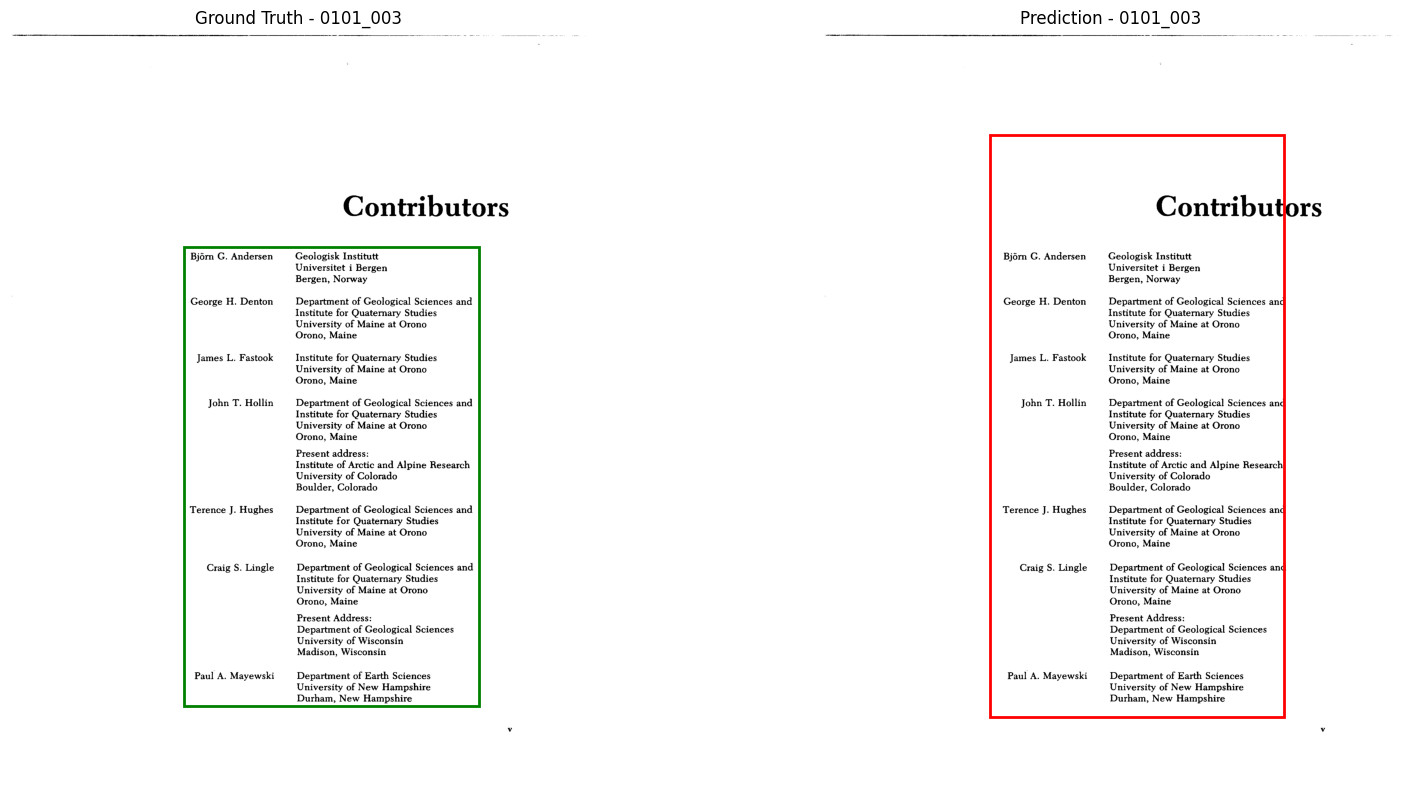

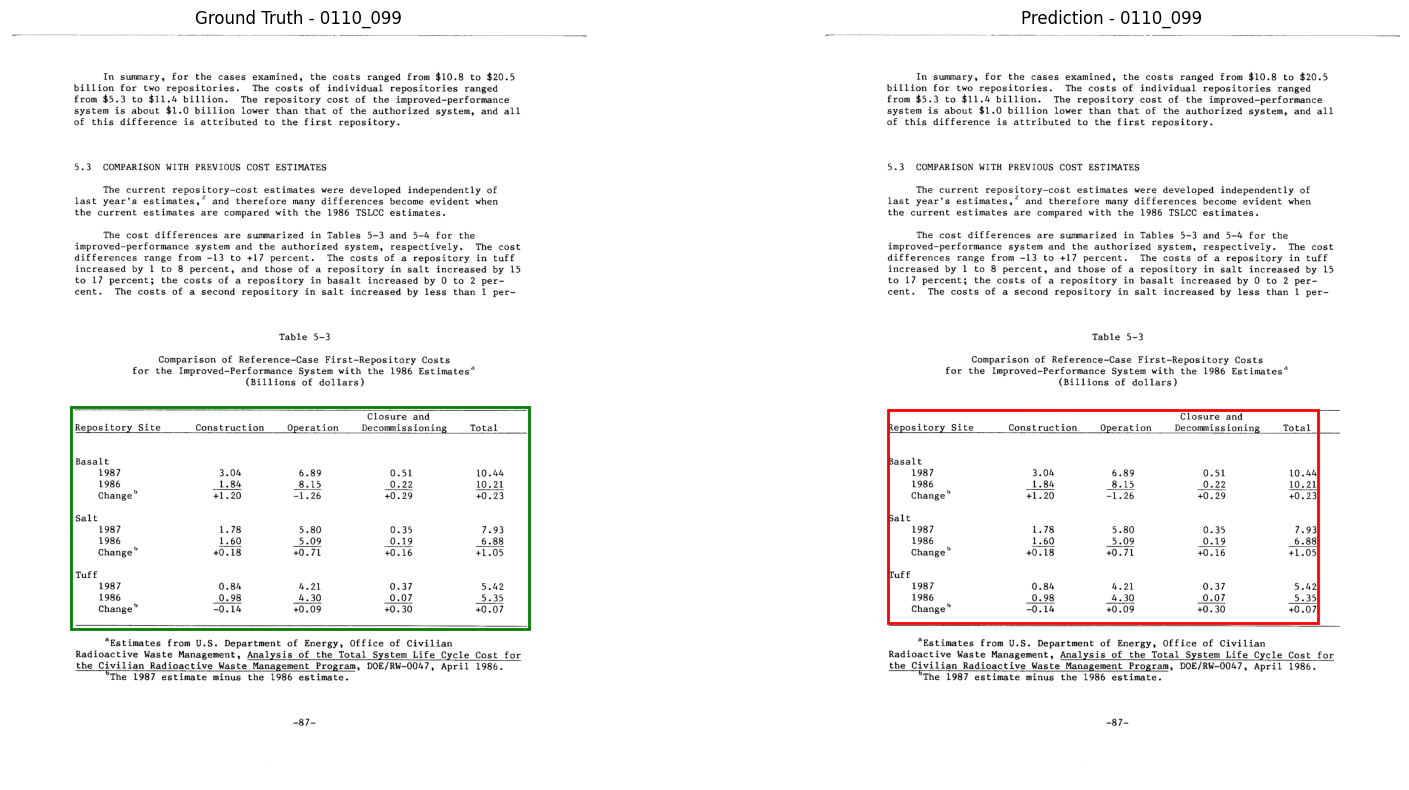

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize(image_path, gt_boxes, pred_boxes, image_id):
    img = Image.open(image_path)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Ground Truth
    ax1.imshow(img)
    for box in gt_boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="green", facecolor="none")
        ax1.add_patch(rect)
    ax1.set_title(f"Ground Truth - {image_id}")
    ax1.axis("off")

    # Predictions
    ax2.imshow(img)
    for box in pred_boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
        ax2.add_patch(rect)
    ax2.set_title(f"Prediction - {image_id}")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize first 3 available test images
count = 0
for image_id in test_df["image_id"].unique():
    if count >= 2:
        break
    gt_rows = test_df[test_df["image_id"] == image_id].dropna(subset=["bbox"])
    if gt_rows.empty:
        continue
    for ext in [".png", ".jpg", ".jpeg"]:
        p = os.path.join(TEST_IMG_DIR, str(image_id) + ext)
        if os.path.exists(p):
            gt_boxes = [eval(r["bbox"]) for _, r in gt_rows.iterrows()]
            pred_boxes = predict_tables(p, model, processor, threshold=0.3)
            visualize(p, gt_boxes, pred_boxes, image_id)
            count += 1
            break